In [1]:
import fsl_mrs.utils.synthetic as syn
from copy import deepcopy
import fsl_mrs.utils.synthetic as syn
from fsl_mrs.core import MRS, basis
import fsl_mrs.dynamic as dyn
from fsl_mrs.utils import plotting as splot
import numpy as np

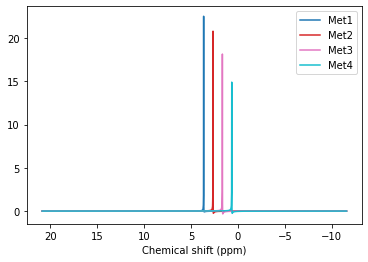

In [2]:
## Make basis set
FID_basis1 = syn.syntheticFID(chemicalshift=[1, ], amplitude=[1], noisecovariance=[[0]], damping=[3])
FID_basis2 = syn.syntheticFID(chemicalshift=[2, ], amplitude=[1], noisecovariance=[[0]], damping=[3])
FID_basis3 = syn.syntheticFID(chemicalshift=[3, ], amplitude=[1], noisecovariance=[[0]], damping=[3])
FID_basis4 = syn.syntheticFID(chemicalshift=[4, ], amplitude=[1], noisecovariance=[[0]], damping=[3])
FID_basis1[1]['fwhm'] = 3 * np.pi
FID_basis2[1]['fwhm'] = 3 * np.pi
FID_basis3[1]['fwhm'] = 3 * np.pi
FID_basis4[1]['fwhm'] = 3 * np.pi
b = basis.Basis(
    np.stack((FID_basis1[0][0].conj(), FID_basis2[0][0].conj(), FID_basis3[0][0].conj(), FID_basis4[0][0].conj()), axis=1),
    ['Met1', 'Met2', 'Met3', 'Met4'],
    [FID_basis1[1], FID_basis2[1], FID_basis3[1], FID_basis4[1]])

_ = b.plot()

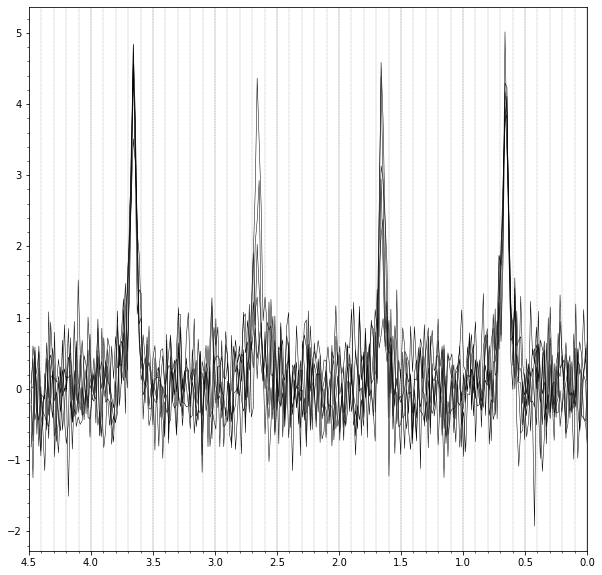

In [39]:
# one metabolite decreases linearly, one exponentially, two fixed
t_vals = np.arange(0, 11, 2)
def gen_mrs_list(noise):
    t_exp = 5
    t_lin = 0.075
    mrs_list = []
    for t in t_vals:
        amps = [1, 1*np.exp(-t/t_exp), 1-t*t_lin, 1]
        fid = syn.syntheticFID(
            chemicalshift=[1, 2, 3, 4],
            amplitude=amps,
            phase=[0, 0, 0, 0],
            damping=[20, 20 ,20 ,20],
            g=[0, 0, 0, 0],
            noisecovariance=[[noise]])
        mrs = MRS(FID=fid[0][0].conj(), header=fid[1], basis=b)
        mrs.check_FID(repair=True)
        mrs.check_Basis(repair=True)
        mrs_list.append(mrs)
    return mrs_list

mrs_list = gen_mrs_list(2E-1)

_ = splot.plot_spectra(mrs_list,plot_avg=False)

conc_Met1           0.979943
conc_Met2_c_amp     1.021434
conc_Met2_c_adc     0.214481
conc_Met3_c_amp     1.002981
conc_Met3_c_lin     0.075095
conc_Met4_t0        1.025061
conc_Met4_t1        0.992778
conc_Met4_t2        1.042742
conc_Met4_t3        0.981274
conc_Met4_t4        0.995967
conc_Met4_t5        1.053718
gamma_1_t0         19.780676
gamma_1_t1         17.659329
gamma_1_t2         17.236100
gamma_1_t3         17.415030
gamma_1_t4         16.689495
gamma_1_t5         18.952163
gamma_0            16.512750
eps_0               1.363635
eps_1               0.952177
Phi_0_0            -0.071251
Phi_1_0            -0.000133
baseline_0          0.005308
baseline_1         -0.003833
baseline_2          0.009872
baseline_3         -0.016903
dtype: float64


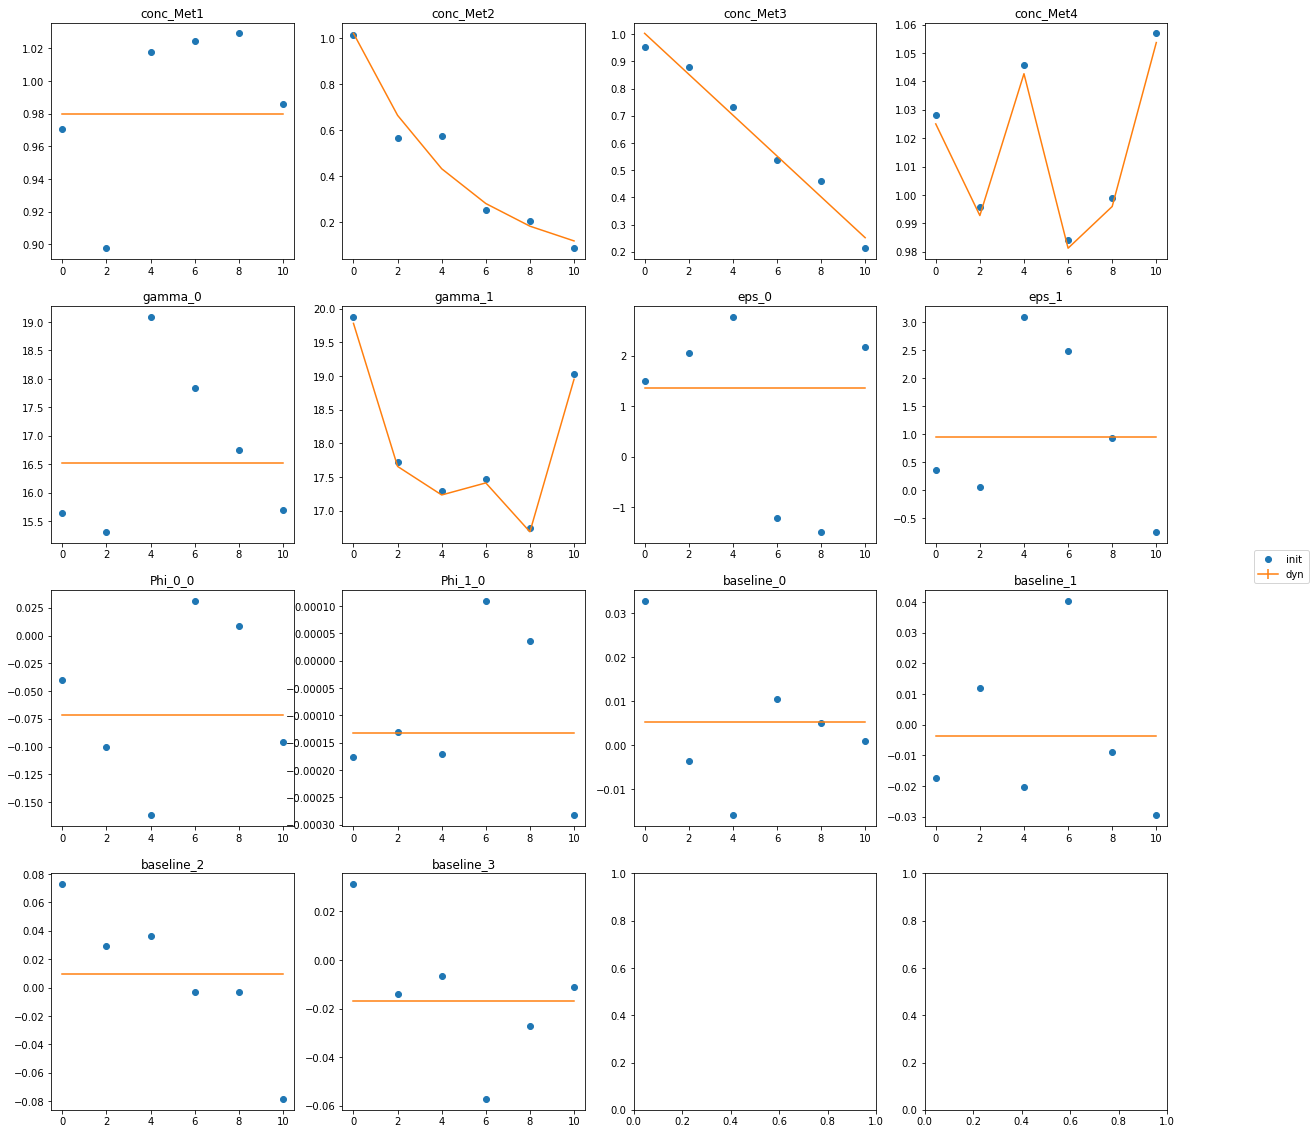

In [40]:
dyn_obj2 = dyn.dynMRS(
        mrs_list,
        t_vals,
        'two_model.py',
        model='lorentzian',
        baseline_order=1,
        metab_groups=[0, 0, 0, 1],
        rescale=False)

init = dyn_obj2.initialise(indiv_init=None)

res = dyn_obj2.fit(init=init)
print(res.mean_free)
_=res.plot_mapped()

In [8]:
dd = np.asarray(dyn_obj2.data).flatten()
resid = dd - dyn_obj2.full_fwd(res.x)
np.var(resid)/2
# plt.plot(resid)

# from fsl_mrs.utils.misc import calculate_lap_cov, gradient
# calculate_lap_cov(res.x, dyn_obj2.full_fwd, dd)

0.0010266078916055903

In [41]:
def noisy_fit(level):
    mrs_list = gen_mrs_list(level)

    dyn_obj2 = dyn.dynMRS(
        mrs_list,
        t_vals,
        'two_model.py',
        model='lorentzian',
        baseline_order=1,
        metab_groups=[0, 0, 0, 1],
        rescale=False)

    init = dyn_obj2.initialise(indiv_init=None)
    res = dyn_obj2.fit(init=init)
    init_free = res.init_free_dataframe
    return res.mean_free, res.std_free, res.cov_free.values, init_free

In [42]:
est_std = []
est_mean = []
est_cov = []
est_init = []

In [43]:
mc_reps = 1000
for idx in range(mc_reps):
    tmp = noisy_fit(1E-3)
    est_mean.append(tmp[0])
    est_std.append(tmp[1])
    est_cov.append(tmp[2])
    est_init.append(tmp[3])

In [44]:
import pandas as pd

mean_values = pd.concat(est_mean, axis=1).T
std_values = pd.concat(est_std, axis=1).T
final_df = pd.concat(
    (mean_values.mean(), std_values.mean(), mean_values.std(), std_values.mean()/ mean_values.std(),100*std_values.std()/std_values.mean() ),
    axis=1,
    keys=['est mean', 'est SD', 'mc SD', 'SD ratio', 'sd % std'])
final_df

,est mean,est SD,mc SD,SD ratio,sd % std
conc_Met1,1.004242e+00,0.002386,0.001830,1.303444,2.533973
conc_Met2_c_amp,1.004108e+00,0.004180,0.003184,1.312562,3.818771
conc_Met2_c_adc,1.999643e-01,0.001524,0.001128,1.351310,1.786913
conc_Met3_c_amp,1.004376e+00,0.003418,0.002582,1.323709,3.035169
conc_Met3_c_lin,7.534273e-02,0.000530,0.000387,1.369915,2.287757
conc_Met4_t0,1.004247e+00,0.006199,0.004994,1.241303,5.321245
conc_Met4_t1,1.004136e+00,0.006197,0.004762,1.301455,5.410099
conc_Met4_t2,1.004319e+00,0.006216,0.005027,1.236684,5.492457
conc_Met4_t3,1.004188e+00,0.006235,0.005020,1.242175,5.402864
conc_Met4_t4,1.004330e+00,0.006249,0.004811,1.298848,5.410001


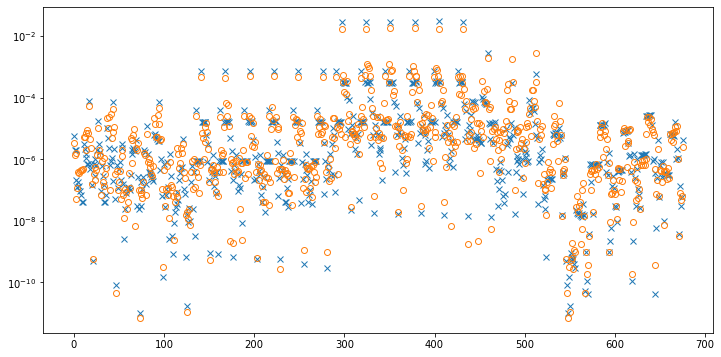

In [45]:
mean_cov = np.asarray(est_cov).mean(axis=0)
mc_cov = mean_values.cov().values

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
plt.semilogy(np.abs(mean_cov.ravel()), 'x')
plt.semilogy(np.abs(mc_cov.ravel()), 'o', markerfacecolor='none')
plt.show()

In [49]:
comp_df['SD ratio'].pow(2)


conc_Met1          1.348678
conc_Met2_c_amp    1.264260
conc_Met2_c_adc    1.188365
conc_Met3_c_amp    1.185075
conc_Met3_c_lin    1.249878
conc_Met4_t0       0.999594
conc_Met4_t1       0.999236
conc_Met4_t2       1.000807
conc_Met4_t3       1.000651
conc_Met4_t4       1.000873
conc_Met4_t5       1.000481
gamma_1_t0         0.999908
gamma_1_t1         1.000382
gamma_1_t2         1.000417
gamma_1_t3         1.000307
gamma_1_t4         1.000406
gamma_1_t5         0.999626
gamma_0            1.323128
eps_0              1.319305
eps_1              1.226264
Phi_0_0            1.286673
Phi_1_0            1.278506
baseline_0         1.255368
baseline_1         1.273625
baseline_2         1.262582
baseline_3         1.293924
Name: SD ratio, dtype: float64

In [58]:
np.sqrt((mean_values.conc_Met1-1).pow(2).sum())
np.sqrt((init_values.conc_Met1-1).pow(2).sum())

0.1510259453914658

In [46]:
init_values = pd.concat(est_init, axis=1).T

comp_df = pd.concat(
    (mean_values.mean(), init_values.mean(), mean_values.std(), init_values.std(), init_values.std()/ mean_values.std()),
    axis=1,
    keys=['dyn mean', 'init mean', 'dyn SD', 'init SD', 'SD ratio',])
comp_df

# comp_df.to_csv('/Users/wclarke/Documents/Conferences/ISMRM2022/presentations/figures/df_comp1E_1.csv')

,dyn mean,init mean,dyn SD,init SD,SD ratio
conc_Met1,1.004242e+00,1.004277e+00,0.001830,0.002126,1.161326
conc_Met2_c_amp,1.004108e+00,1.004209e+00,0.003184,0.003581,1.124393
conc_Met2_c_adc,1.999643e-01,1.999923e-01,0.001128,0.001229,1.090122
conc_Met3_c_amp,1.004376e+00,1.004479e+00,0.002582,0.002811,1.088611
conc_Met3_c_lin,7.534273e-02,7.535967e-02,0.000387,0.000432,1.117979
conc_Met4_t0,1.004247e+00,1.004244e+00,0.004994,0.004993,0.999797
conc_Met4_t1,1.004136e+00,1.004134e+00,0.004762,0.004760,0.999618
conc_Met4_t2,1.004319e+00,1.004316e+00,0.005027,0.005029,1.000404
conc_Met4_t3,1.004188e+00,1.004186e+00,0.005020,0.005021,1.000325
conc_Met4_t4,1.004330e+00,1.004328e+00,0.004811,0.004813,1.000436
